# Lab 1: Sentiment Analysis with Logistic Regression using PyTorch

## Introduction

In this lab session we will implement a Logistic Regression model for __sentence classification__ using PyTorch. Given a sentence, our model will predict if it is a positive or negative piece of text. The dataset we are going to use ranges the polarity annotation from 0 to 5, where 0 denotes extremely negative sentiment and 5 is the most positive.

Nevertheless, for this lab we'll simplify the task by translating the 5-way classification task into a 2-way classification task (0 $\rightarrow$ _negative_, 1 $\rightarrow$ _positive_).

All in all, the main __objectives__ of this first laboratory are the following:
- Learn how to build, train and evaluate a Logistic Regression model in PyTorch
- Preprocess the input (e.g., one-hot-encoding)
- Explore hyperparameters like:
  - learning rates
  - number of epochs
- Plot learning curves for model selection


## 1. Loading the data

Let's load the Stanford Sentiment Treebank.  The data can be originaly downloaded from here: [the train/dev/test Stanford Sentiment Treebank distribution](http://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip).

In order to load the data, you will need to mount your Drive folder first and give the access to the Notebook. This will require one-step authentication. Please when you run the cell below follow the instructions.

Once you mount everything, make sure ```sst_home = 'drive/My Drive/Colab Notebooks/dl4nlp_summer_labs/utils/sst_custom_loader'``` is the correct path for the custom data loader script. We will use the load_data function of the datasets library. In this case, we will use a custom data loader to download the data and process it for our lab, but you can download tons of data from https://huggingface.co/datasets directly.


Please run the following cells to load the data.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# install libraries
!pip install pytorch
!pip install datasets==2.17.1
# import load_dataset from dataset
from datasets import load_dataset
# set seed for replicability of results
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from collections import Counter
import time
np.random.seed(2)

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pytorch)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does no

**Note:** Don't worry about the error (warning). This is because we are installing datasets==2.17.1 and some pre-installed libraries are not compatible. It will not cause any problems for our executions.

In [4]:
print(torch.__version__)

2.8.0+cu126


In [5]:
# custom data loader path ALDATU
home = '/content/drive/MyDrive/Colab Notebooks/dl4nlp_summer_labs/'
sst_home = home + 'utils/sst_custom_loader.py'
# load data with load_dataset and our custom data loader script
data = load_dataset(sst_home)
training_set = pd.DataFrame(data['train'])
dev_set = pd.DataFrame(data['validation'])
test_set = pd.DataFrame(data['test'])

print('Training size: {}'.format(len(training_set)))
print('Dev size: {}'.format(len(dev_set)))
print('Test size: {}'.format(len(test_set)))

/usr/local/lib/python3.12/dist-packages/datasets/load.py:923: FutureWarning: The repository for sst_custom_loader contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at /content/drive/MyDrive/Colab Notebooks/dl4nlp_summer_labs/utils/sst_custom_loader.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Training size: 6920
Dev size: 872
Test size: 1821


## 2. Examining the data

In [6]:
pd.set_option('max_colwidth', 1000)
# Print a sample of negative text chunks
training_set[training_set.label == 0].head(10)

,label,text
22,0,This is n't a new idea .
34,0,... a sour little movie at its core ; an exploration of the emptiness that underlay the relentless gaiety of the 1920 's ... The film 's ending has a `` What was it all for ? ''
37,0,Made me unintentionally famous -- as the queasy-stomached critic who staggered from the theater and blacked out in the lobby .
52,0,The modern-day royals have nothing on these guys when it comes to scandals .
53,0,It 's only in fairy tales that princesses that are married for political reason live happily ever after .
59,0,An absurdist spider web .
76,0,"By no means a slam-dunk and sure to ultimately disappoint the action fans who will be moved to the edge of their seats by the dynamic first act , it still comes off as a touching , transcendent love story ."
110,0,It 's not a great monster movie .
144,0,"Too often , Son of the Bride becomes an exercise in trying to predict when a preordained `` big moment '' will occur and not `` if . ''"
148,0,A party-hearty teen flick that scalds like acid .


In [7]:
# Print a sample of positive text chunks
training_set[training_set.label == 1].head(10)

,label,text
0,1,"The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal ."
1,1,The gorgeously elaborate continuation of `` The Lord of the Rings '' trilogy is so huge that a column of words can not adequately describe co-writer\/director Peter Jackson 's expanded vision of J.R.R. Tolkien 's Middle-earth .
2,1,"Singer\/composer Bryan Adams contributes a slew of songs -- a few potential hits , a few more simply intrusive to the story -- but the whole package certainly captures the intended , er , spirit of the piece ."
3,1,Yet the act is still charming here .
4,1,"Whether or not you 're enlightened by any of Derrida 's lectures on `` the other '' and `` the self , '' Derrida is an undeniably fascinating and playful fellow ."
5,1,Just the labour involved in creating the layered richness of the imagery in this chiaroscuro of madness and light is astonishing .
6,1,Part of the charm of Satin Rouge is that it avoids the obvious with humour and lightness .
7,1,a screenplay more ingeniously constructed than `` Memento ''
8,1,`` Extreme Ops '' exceeds expectations .
9,1,"Good fun , good action , good acting , good dialogue , good pace , good cinematography ."


## 3. Preprocessing the data
Once data is loaded the next step is to preprocess it to obtain the vectorized form (i.e. the process of transforming text into numeric tensors), which basically consists of:

- Tokenization: typically segment the text into words (alternatively, characters or n-grams)
- Definition of the dictionary index and vocabulary size (in this case we set 1000 most frequent words)
- Transform each word into a vector

There are multiple ways to vectorize tokens. The main two are the following: ___one-hot encoding___ and ___word embeddings___. In this lab, we'll implement one-hot encoding with a simple PyTorch-compatible tokenizer, and we'll leave word embeddings for successive labs.

In [8]:
from sklearn.utils import shuffle

# Shuffle dataset
training_set = shuffle(training_set)
dev_set = shuffle(dev_set)
test_set = shuffle(test_set)

# Obtain text and label vectors, and tokenize the text
train_texts = training_set.text
train_labels = training_set.label

dev_texts = dev_set.text
dev_labels = dev_set.label

test_texts = test_set.text
test_labels = test_set.label

In [9]:
print(training_set.loc[0])
print(train_labels.loc[0])

label                                                                                                                                                                                        1
text     The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .
Name: 0, dtype: object
1


### 3.1. One-hot encoding of the data

One-hot encoding is the most basic way to convert a token into a vector. Here, we'll turn the input vectors into (0,1)-vectors. The process consists of associating a unique integer index with every word in the vocabulary.

>>>>>![](http://ixa2.si.ehu.es/~jibloleo/uc3m_dl4nlp/img/vectorize_small.png)

For example, if the tokenized vector contains a word whose dictionary index is 14, then in the processed vector, the 14th entry of the vector will be 1 and the rest will be set to 0.

Note that in our tokenizer implementation, ```0``` is a reserved index that won't be assigned to any word.

In [10]:
import torch
import re
from collections import Counter
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(2)
np.random.seed(2)

class PyTorchTokenizer:
    def __init__(self, num_words=1000):
        self.num_words = num_words
        self.word_index = {}
        self.word_counts = {}

    def fit_on_texts(self, texts):
        word_counts = Counter()

        for text in texts:
            # simple tokenization - split on whitespace and punctuation
            words = text.split()
            words = [word for word in words if word not in [",", "."]]
            word_counts.update(words)

        # keep only the most frequent words
        most_common = word_counts.most_common(self.num_words - 1)

        # build word index (starting from 1, 0 is reserved)
        self.word_index = {word: idx + 1 for idx, (word, count) in enumerate(most_common)}
        self.word_counts = dict(most_common)

    def texts_to_matrix(self, texts):
        matrix = torch.zeros(len(texts), self.num_words)

        # build the matrix
        for i, text in enumerate(texts):
            words = re.findall(r'\b\w+\b', text.lower())
            for word in words:
                if word in self.word_index:
                    word_idx = self.word_index[word]
                    if word_idx < self.num_words:
                        matrix[i, word_idx] = 1.0

        return matrix

# Create a tokenizer that takes the 1000 most common words
tokenizer = PyTorchTokenizer(num_words=1000)

# Build the word index (dictionary)
tokenizer.fit_on_texts(train_texts)  # Create word index using only training part

# Vectorize texts into one-hot encoding representations
x_train = tokenizer.texts_to_matrix(train_texts)
x_dev = tokenizer.texts_to_matrix(dev_texts)
x_test = tokenizer.texts_to_matrix(test_texts)

# Converts the labels to a one-hot representation
y_train = torch.tensor(train_labels.values, dtype=torch.float32).unsqueeze(1)
y_dev = torch.tensor(dev_labels.values, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(test_labels.values, dtype=torch.float32).unsqueeze(1)

# Create datasets using PyTorch's TensorDataset
train_dataset = TensorDataset(x_train, y_train)
dev_dataset = TensorDataset(x_dev, y_dev)
test_dataset = TensorDataset(x_test, y_test)

print('Text of the first examples: \n{}\n'.format(train_texts.iloc[0]))
print('Vector of the first example:\n{}\n'.format(x_train[0]))
print('Binary representation of the output:\n{}\n'.format(y_train[0]))
print('Shape of the training set    (nb_examples, vector_size): {}\n'.format(x_train.shape))
print('Shape of the training labels (nb_examples, vector_size): {}\n'.format(y_train.shape))

Text of the first examples: 
This rush to profits has created a predictably efficient piece of business notable largely for its overwhelming creepiness , for an eagerness to create images you wish you had n't seen , which , in this day and age , is of course the point .

Vector of the first example:
tensor([0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [11]:
# Recover the word index that was created with the tokenizer
print("Show the most frequent word and count:")
for word, count in list(tokenizer.word_counts.items())[:10]:
    print(f"   {word} --> {count}")
print("Show the less frequent word and count:")
for word, count in list(tokenizer.word_counts.items())[-10:]:
    print(f"   {word} --> {count}")

Show the most frequent word and count:
   the --> 4932
   and --> 3794
   of --> 3623
   a --> 3607
   to --> 2415
   is --> 2077
   's --> 2025
   that --> 1583
   in --> 1478
   it --> 1433
Show the less frequent word and count:
   wise --> 13
   credit --> 13
   typical --> 13
   Both --> 13
   World --> 13
   stars --> 13
   meditation --> 13
   Does --> 13
   date --> 13
   suffers --> 13


Check what we obtain when we vectorize words that are out of the index (_out of vocabulary_ words).

In [12]:
oov_sample = ['saddam', 'plausible']
sequences = tokenizer.texts_to_matrix(oov_sample)
print(sequences[0])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

## 4. Building the model architecture
When we build a neural network we usually take into account the following points:
- The __layers__, and how they are combined (that is, the structure and parameters of the model)
- The __input__ and the __labeled output__ data that the model needs to map
- The __loss function__ that signals how well the model is doing
- The __optimizer__ which defines the learning procedure

In this very first session we'll keep everything simple. In PyTorch, we'll implement logistic regression as a single linear layer (`nn.Linear`) followed by a sigmoid nonlinearity in the `forward` pass.

In this session, we will build a __logistic regression__ which is the simplest neural network model. More complicated models, like the multilayer perceptron, will be learned in the next lab sessions.

The logistic regression in PyTorch computes:

> ```output = sigmoid(X @ W + b)```

where `sigmoid` is the element-wise activation function, `W` is the weight matrix of the linear layer, and `b` is the bias vector.

Remember from the slides that mathematically this can be written as follows (where $W$ is the weights and $X$ is the input):
> $sigmoid(W^{T}X + b)$

Regarding input data, we will use __one-hot encoding__ (see previous sections). We'll set binary cross-entropy (`nn.BCELoss`) as the __loss function__ and `torch.optim.Adam`, a variant of Stochastic Gradient Descent, as the __optimizer__. We will use the default learning rate (0.001). In PyTorch you can inspect it via `optimizer.param_groups[0]['lr']`.

Feel free to explore different loss functions (e.g., MSE) and optimizers (e.g., RMSprop) to improve the model (see Exercise 2, below).

In [13]:
class LinearClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.classifier = nn.Linear(input_dim, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input, target=None):
        logits = self.classifier(input)
        probs = self.sigmoid(logits)
        if target is not None: # compute loss if desired targets are given
          loss = nn.BCELoss()(probs, target)
        else:
          loss = None
        return logits, probs, loss

### Exercise 1
Answer the following questions:
- How many layers has the model?  **Only one**.  
- What is the input size? **1000, the size of the vocabulary**.
- How many parameters has the models? What is the relationship with the input size? **1001, 1000 due to input size, plus 1 due to bias**.

## 5. Training the model
Next, we train the model defined above using a standard PyTorch training loop.

Our helper function `train_loop(model, optimizer, epochs)` returns a `history` dictionary containing the train/dev accuracies and losses for each of the 50 epochs, which we can plot easily.

In [14]:
@torch.no_grad()
def evaluate(model, data_loader):
    model.eval()

    total_loss = 0
    correct = 0
    total = 0

    for xb, yb in data_loader:
        # forward pass
        _, probs, loss = model(xb, yb)
        total_loss += loss.item() * xb.size(0)

        preds = (probs > 0.5).float()
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    loss = total_loss / total
    acc = correct / total
    model.train()

    return loss, acc


def train_loop(model, optimizer, epochs):

    # train mode for model
    model.train()

    history = {"loss": [], "dev_loss": [], "acc": [], "dev_acc": []}
    t0 = time.time()
    t_prev = t0

    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        dataiter = iter(train_loader)
        for batch in dataiter:
            xb, yb = batch

            # zero gradients
            optimizer.zero_grad()

            # forward pass
            _, probs, loss = model(xb, yb)

            # backward pass
            loss.backward()

            # optimizer step
            optimizer.step()

            # compute metrics
            total_loss += loss.item() * xb.size(0)
            total += yb.size(0)
            with torch.no_grad():
                preds = (probs > 0.5).float()
                correct += (preds == yb).sum().item()

        loss = total_loss / total
        acc = correct / total

        # Evaluation
        dev_loss, dev_acc = evaluate(model, dev_loader)

        # Store info
        history["loss"].append(loss)
        history["dev_loss"].append(dev_loss)
        history["acc"].append(acc)
        history["dev_acc"].append(dev_acc)

        # Logging
        t = time.time()
        print(
            f"Epoch {epoch+1}/{epochs} - "
            f"Train loss: {loss:.4f} - "
            f"Train acc: {acc:.4f} - "
            f"Dev loss: {dev_loss:.4f} - "
            f"Dev acc: {dev_acc:.4f} - "
            f"Time: {(t - t_prev)*1000:.2f}ms"
        )

        # Updates
        t_prev = t

    print(f"Total training time: {t-t0}")
    return history

In [15]:
# TODO Run the model. Feel free to experiment with different batch sizes and number of epochs.

########################################
# hyperparameters
########################################
learning_rate = 0.00100
epochs = 50
batch_size = 32

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# model
model = LinearClassifier(x_train.shape[1], 1) # just one class, which can be 0 or 1

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# execute the train loop
history = train_loop(model, optimizer, epochs)

Epoch 1/50 - Train loss: 0.6764 - Train acc: 0.6095 - Dev loss: 0.6562 - Dev acc: 0.6984 - Time: 430.32ms
Epoch 2/50 - Train loss: 0.6436 - Train acc: 0.7145 - Dev loss: 0.6299 - Dev acc: 0.6984 - Time: 303.01ms
Epoch 3/50 - Train loss: 0.6183 - Train acc: 0.7298 - Dev loss: 0.6096 - Dev acc: 0.7122 - Time: 284.27ms
Epoch 4/50 - Train loss: 0.5977 - Train acc: 0.7386 - Dev loss: 0.5933 - Dev acc: 0.7362 - Time: 236.01ms
Epoch 5/50 - Train loss: 0.5807 - Train acc: 0.7493 - Dev loss: 0.5806 - Dev acc: 0.7362 - Time: 255.46ms
Epoch 6/50 - Train loss: 0.5661 - Train acc: 0.7540 - Dev loss: 0.5701 - Dev acc: 0.7385 - Time: 212.37ms
Epoch 7/50 - Train loss: 0.5537 - Train acc: 0.7611 - Dev loss: 0.5611 - Dev acc: 0.7420 - Time: 231.21ms
Epoch 8/50 - Train loss: 0.5426 - Train acc: 0.7675 - Dev loss: 0.5538 - Dev acc: 0.7374 - Time: 225.51ms
Epoch 9/50 - Train loss: 0.5330 - Train acc: 0.7691 - Dev loss: 0.5473 - Dev acc: 0.7500 - Time: 204.38ms
Epoch 10/50 - Train loss: 0.5244 - Train acc: 

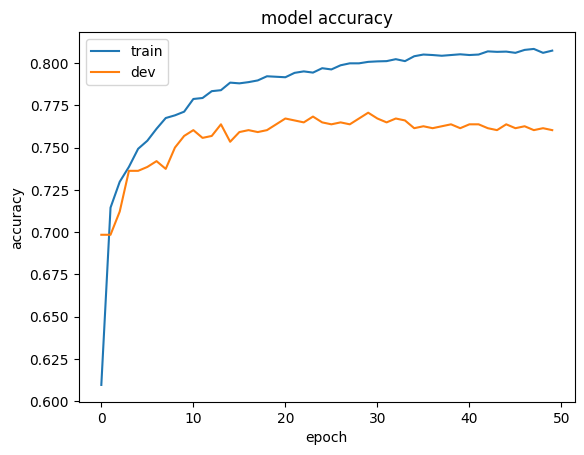

In [16]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history['acc'])
plt.plot(history['dev_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

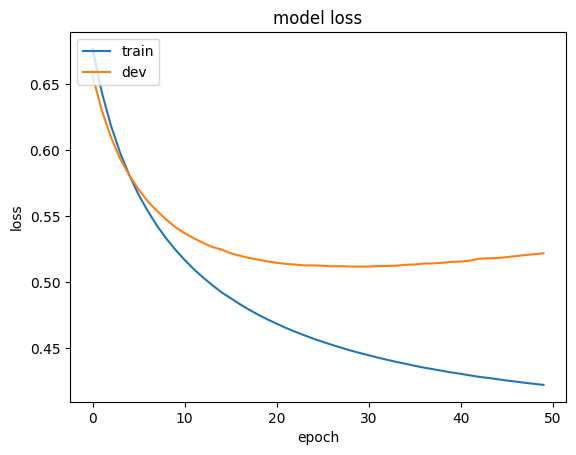

In [17]:
plt.plot(history['loss'])
plt.plot(history['dev_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

## 6. Evaluating the model

Once training is finished, we use our `evaluate(model, test_loader)` helper to compute loss and accuracy on the test set.

In [18]:
test_loss, test_acc = evaluate(model, test_loader)
print("Loss: ", test_loss)
print("Accuracy: ", test_acc)

Loss:  0.4932622703008112
Accuracy:  0.7539813289401428


## 7. Model Tuning

### 7.1. Effect of Learning Rate

#### Exercise 2
In this session we'll focus on the importance of the learning rate. We'll compare a large and a small learning rate with the default one.


__Please run the following cells and answers to the next questions:__

- Why we obtain such a different plots with each learning rate?

- What is the difference when comparing the following curves:
   - ```train large``` vs  ```train orig```
   - ```dev large``` vs  ```dev orig```

- And the following ones:
   - ```train small``` vs  ```train orig```
   - ```dev small``` vs ```dev orig```




In [19]:
class LinearClassifierWithL2Regularization(nn.Module):
    def __init__(self, input_dim, num_classes, l2_reg=0.0):
        super().__init__()
        self.classifier = nn.Linear(input_dim, num_classes)
        self.sigmoid = nn.Sigmoid()
        self.l2_reg = l2_reg

    def forward(self, input, target=None):
        logits = self.classifier(input)
        probs = self.sigmoid(logits)
        if target is not None: # compute loss if desired targets are given
          bce_loss = nn.BCELoss()(probs, target)
          # Add L2 regularization
          l2_loss = 0
          for param in self.parameters():
              l2_loss += torch.sum(param.pow(2))
          loss = bce_loss + self.l2_reg * l2_loss
        else:
          loss = None
        return logits, probs, loss

In [20]:
# model, optimizer, execute the train loop
model2 = LinearClassifierWithL2Regularization(x_train.shape[1], 1, 0.0) # just one class, which can be 0 or 1
optimizer_small = torch.optim.Adam(model2.parameters(), lr=0.00001)
history_small = train_loop(model2, optimizer_small, epochs)

# model, optimizer, execute the train loop
model2 = LinearClassifierWithL2Regularization(x_train.shape[1], 1, 0.0) # just one class, which can be 0 or 1
optimizer_large = torch.optim.Adam(model2.parameters(), lr=0.5)
history_large = train_loop(model2, optimizer_large, epochs)

Epoch 1/50 - Train loss: 0.6929 - Train acc: 0.5142 - Dev loss: 0.6936 - Dev acc: 0.4702 - Time: 198.80ms
Epoch 2/50 - Train loss: 0.6924 - Train acc: 0.5215 - Dev loss: 0.6932 - Dev acc: 0.4828 - Time: 205.10ms
Epoch 3/50 - Train loss: 0.6919 - Train acc: 0.5302 - Dev loss: 0.6927 - Dev acc: 0.4908 - Time: 193.46ms
Epoch 4/50 - Train loss: 0.6914 - Train acc: 0.5338 - Dev loss: 0.6923 - Dev acc: 0.4931 - Time: 195.68ms
Epoch 5/50 - Train loss: 0.6909 - Train acc: 0.5399 - Dev loss: 0.6918 - Dev acc: 0.5138 - Time: 195.55ms
Epoch 6/50 - Train loss: 0.6905 - Train acc: 0.5488 - Dev loss: 0.6914 - Dev acc: 0.5195 - Time: 211.39ms
Epoch 7/50 - Train loss: 0.6900 - Train acc: 0.5548 - Dev loss: 0.6909 - Dev acc: 0.5287 - Time: 198.61ms
Epoch 8/50 - Train loss: 0.6895 - Train acc: 0.5594 - Dev loss: 0.6905 - Dev acc: 0.5333 - Time: 187.31ms
Epoch 9/50 - Train loss: 0.6891 - Train acc: 0.5663 - Dev loss: 0.6900 - Dev acc: 0.5436 - Time: 190.61ms
Epoch 10/50 - Train loss: 0.6886 - Train acc: 

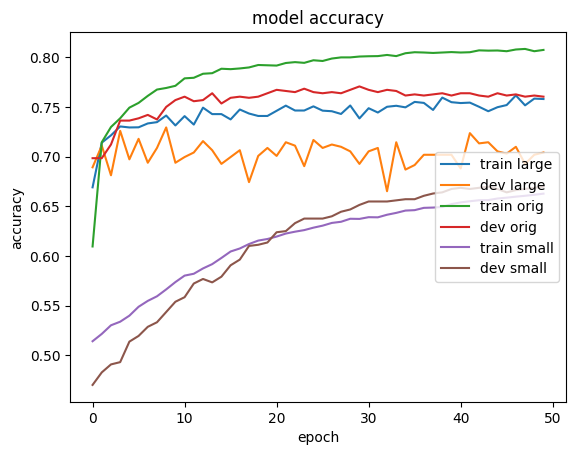

In [21]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history_large['acc'])
plt.plot(history_large['dev_acc'])

plt.plot(history['acc'])
plt.plot(history['dev_acc'])

plt.plot(history_small['acc'])
plt.plot(history_small['dev_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train large', 'dev large', 'train orig', 'dev orig', 'train small', 'dev small'], loc='center right')
plt.show()

The learning rate has a direct impact on the model estimation. If see the small learning rate and train for a fixed epochs (let say, 50) the model will has a huge bias:
- The model is far from memorizing the training set, and the difference of the accuracy between training and development is minimum.

If the model is using a large learning rate, the model will overfit very fast:
- The model stacks on a plateau very fast. It looks like the model ended up in local minima.


### 7.2. Improving The Baseline Model

#### Exercise 3

The model in previus section uses learning reate values that might not be optimum ones. It would be great if you could try improving the model by exploring different hyperparameters. For example,  you can explore the following ones:
- Learning rates of the optimizer.
- Number of epochs.
- Vocabulary size (using larger set of words).


In [22]:
# Create a tokenizer that takes the 10000 most common words
tokenizer = PyTorchTokenizer(num_words=10000)

# Build the word index (dictionary)
tokenizer.fit_on_texts(train_texts)  # Create word index using only training part

# Vectorize texts into one-hot encoding representations
x_train = tokenizer.texts_to_matrix(train_texts)
x_dev = tokenizer.texts_to_matrix(dev_texts)
x_test = tokenizer.texts_to_matrix(test_texts)

# Converts the labels to a one-hot representation
y_train = torch.tensor(train_labels.values, dtype=torch.float32).unsqueeze(1)
y_dev = torch.tensor(dev_labels.values, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(test_labels.values, dtype=torch.float32).unsqueeze(1)

# Create datasets using PyTorch's TensorDataset
train_dataset = TensorDataset(x_train, y_train)
dev_dataset = TensorDataset(x_dev, y_dev)
test_dataset = TensorDataset(x_test, y_test)

print('Text of the first examples: \n{}\n'.format(train_texts.iloc[0]))
print('Vector of the first example:\n{}\n'.format(x_train[0]))
print('Binary representation of the output:\n{}\n'.format(y_train[0]))
print('Shape of the training set    (nb_examples, vector_size): {}\n'.format(x_train.shape))
print('Shape of the training labels (nb_examples, vector_size): {}\n'.format(y_train.shape))

Text of the first examples: 
This rush to profits has created a predictably efficient piece of business notable largely for its overwhelming creepiness , for an eagerness to create images you wish you had n't seen , which , in this day and age , is of course the point .

Vector of the first example:
tensor([0., 1., 1.,  ..., 0., 0., 0.])

Binary representation of the output:
tensor([1.])

Shape of the training set    (nb_examples, vector_size): torch.Size([6920, 10000])

Shape of the training labels (nb_examples, vector_size): torch.Size([6920, 1])



In [23]:
########################################
# hyperparameters
########################################
lrs = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5]
epochs = 50
batch_size = 32

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

history = {}
for lr in lrs:

    # model
    model = LinearClassifierWithL2Regularization(x_train.shape[1], 1, 0.0)

    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # execute the train loop
    history[lr] = train_loop(model, optimizer, epochs)

Epoch 1/50 - Train loss: 0.6933 - Train acc: 0.5007 - Dev loss: 0.6924 - Dev acc: 0.5206 - Time: 237.80ms
Epoch 2/50 - Train loss: 0.6926 - Train acc: 0.5253 - Dev loss: 0.6918 - Dev acc: 0.5470 - Time: 227.39ms
Epoch 3/50 - Train loss: 0.6919 - Train acc: 0.5504 - Dev loss: 0.6913 - Dev acc: 0.5814 - Time: 245.23ms
Epoch 4/50 - Train loss: 0.6912 - Train acc: 0.5710 - Dev loss: 0.6907 - Dev acc: 0.6067 - Time: 257.44ms
Epoch 5/50 - Train loss: 0.6905 - Train acc: 0.5929 - Dev loss: 0.6902 - Dev acc: 0.6284 - Time: 248.02ms
Epoch 6/50 - Train loss: 0.6898 - Train acc: 0.6120 - Dev loss: 0.6896 - Dev acc: 0.6365 - Time: 224.78ms
Epoch 7/50 - Train loss: 0.6892 - Train acc: 0.6295 - Dev loss: 0.6891 - Dev acc: 0.6479 - Time: 231.58ms
Epoch 8/50 - Train loss: 0.6885 - Train acc: 0.6436 - Dev loss: 0.6885 - Dev acc: 0.6583 - Time: 238.82ms
Epoch 9/50 - Train loss: 0.6878 - Train acc: 0.6507 - Dev loss: 0.6880 - Dev acc: 0.6640 - Time: 249.86ms
Epoch 10/50 - Train loss: 0.6872 - Train acc: 

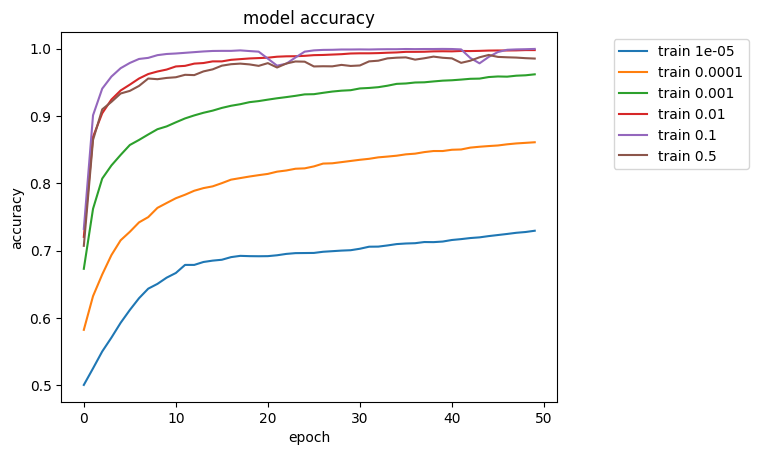

In [24]:
import matplotlib.pyplot as plt

# summarize history for accuracy
legend=[]
for lr in lrs:
    plt.plot(history[lr]['acc'])
    legend.append('train {}'.format(lr))

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(legend, bbox_to_anchor=(1.4, 1), loc='upper right')
plt.show()

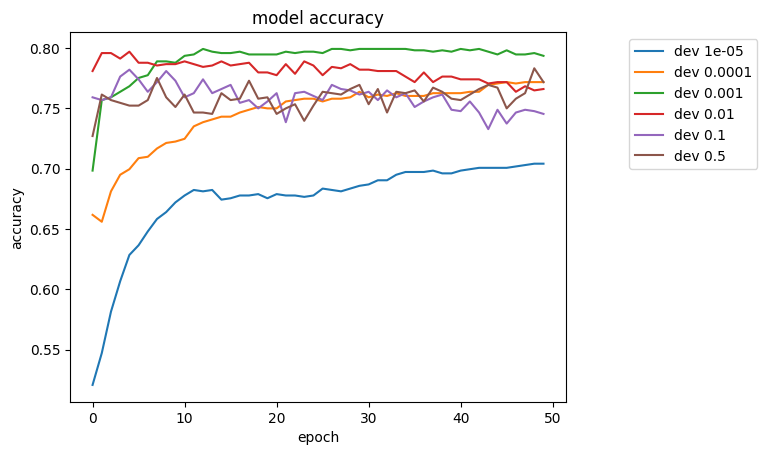

In [25]:
import matplotlib.pyplot as plt

# summarize history for accuracy
legend=[]
for lr in lrs:
    plt.plot(history[lr]['dev_acc'])
    legend.append('dev {}'.format(lr))

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(legend, bbox_to_anchor=(1.4, 1), loc='upper right')
plt.show()

In [26]:
best_epochs = []
accs = []
for lr in lrs:
    index = np.argmax(history[lr]['dev_acc'])
    best_epochs.append(index+1)
    accs.append(history[lr]['dev_acc'][index])
pd.DataFrame(data={'lr': lrs, 'best_epoch':best_epochs, 'acc':accs})

,lr,best_epoch,acc
0,0.00001,49,0.704128
1,0.00010,46,0.771789
2,0.00100,13,0.799312
3,0.01000,5,0.797018
4,0.10000,5,0.782110
5,0.50000,49,0.783257
